# New Ingredient Image Analysis

## Questions

### Products with Ingredient Images

- 1,017,429 products (27.7%) have ingredient image, of which
  - 961,041 products (94.5%) have state tag `en:ingredients-photo-selected` -> 56,398 (5.5%) missing. 🤔
  - 639,044 products (62.2%) have identified ingredients (known, unknown)
  - ?? completed
  - ?? ingredient analysis ok

- 1,017,429 products (27.7%) have ingredient image, of which
  - 895,262 products (88.0%) have one ingredient image.
  - 108,168 products (10.6%) have two ingredient images.
  -  14,009 products ( 1.4%) have three or more ingredient images.

- 1,163,301 ingredient images, of which in languages
  - 579,762 (57.0%) fr 🇫🇷
  - 212,462 (20.9%) en 🇬🇧🇺🇸
  - 107,551 (10.6%) de 🇩🇪
  -  78,250 ( 7.7%) es 🇪🇸
  -  46,234 ( 4.5%) unknown ❓🤔
  - 139,042 (13.7%) in 111 other languages 🌎

### Recognized Ingredients

- ?? products have percent analysis ok

### To be done:
- age of ingredient images
    - what is the age of ingredient images per language
- OCR
    - how many photos have extracted text?
    - are extractions missing for some languages?
- Recognition
    - What are the most unrecognized ingredients per image?
        - What is the main reason for these errors? (OCR, spelling, missing taxonomy?)
- Percentage Analysis
    - How many have analyzed percentages?
    - What is the main reason for failed percentage analysis?

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
%%time
file_path = "../data/ingredients_data_export_jq8.csv.gz"
df = pd.read_csv(file_path, dtype={'code':str})
df = df[df.code.notna()].set_index('code') # exclude empty barcodes

# use Int64 to counts with NaN
for col in ['ingredients_n', 'known_ingredients_n', 'unknown_ingredients_n', 'ingredients_percent_analysis']:
    df[col] = df[col].astype('Int64')

display(df)

,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,ingredients_tags,images_keys,images,states,quality_info
code,,,,,,,,,,,
0000101209159,<NA>,<NA>,<NA>,False,<NA>,NaN,NaN,ingredients_fr,"{""ingredients_fr"":{""imgid"":""2"",""uploader"":""kil...","en:ingredients-to-be-completed,en:ingredients-...",NaN
0000105000011,1,3,0,True,1,CHAMOMILE FLOWERS.,"en:camomile-flower,en:herb,en:camomile",NaN,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000042,1,3,0,True,1,Peppermint.,"en:peppermint,en:herb,en:mint",NaN,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000059,1,0,1,True,1,LINDEN FLOWERS.,en:linden-flowers,NaN,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
0000105000073,1,2,0,True,1,Hibiscus flowers.,"en:roselle-flower,en:plant",NaN,NaN,en:ingredients-completed,en:ingredients-percent-analysis-ok
...,...,...,...,...,...,...,...,...,...,...,...
8718907242424,<NA>,<NA>,<NA>,False,<NA>,NaN,NaN,NaN,NaN,en:ingredients-to-be-completed,NaN
0007405956277,<NA>,<NA>,<NA>,False,<NA>,NaN,NaN,NaN,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN
3760019590615,<NA>,<NA>,<NA>,False,<NA>,NaN,NaN,NaN,NaN,"en:ingredients-to-be-completed,en:ingredients-...",NaN


CPU times: user 12.5 s, sys: 1.82 s, total: 14.3 s
Wall time: 15.8 s


## Analyze Ingredient Images

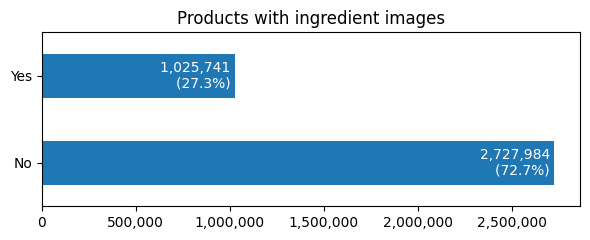

In [3]:
ax = df.images_keys.notna().value_counts().plot.barh(title='Products with ingredient images', figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f'{width:,} \n({width / len(df) * 100:.1f}%) ', va='center', ha='right', color='white')

ax.set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

In [4]:
df_images = df[df.images_keys.notna()]

## Marked as Selected

In [5]:
print("selected total:", df.states.str.contains('en:ingredients-photo-selected').sum())
print("selected image:", df_images.states.str.contains('en:ingredients-photo-selected').sum())
print("selected percent:", "{:.1f}%".format(df.states.str.contains('en:ingredients-photo-selected').sum() / len(df_images) * 100))
print("selected diff:", "{:,}".format(len(df_images) - df.states.str.contains('en:ingredients-photo-selected').sum()))

selected total: 968681
selected image: 968681
selected percent: 94.4%
selected diff: 57,060


## Number of Ingredient Images

images_keys
1     902,740
2     108,863
3+     14,138
Name: count, dtype: object

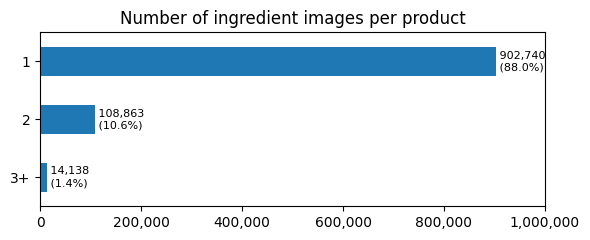

In [6]:
img_counts = df_images.images_keys.str.split(',').map(len).map(lambda x: "3+" if x >= 3 else str(x))
display(img_counts.value_counts().sort_index().map("{:,}".format))

ax = img_counts.value_counts().sort_index(ascending=False).plot.barh(title='Number of ingredient images per product', figsize=(6,2.5))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 1e6)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_images) * 100:.1f}%)', va='center', ha='left', fontsize=8)
    
plt.tight_layout()
plt.show()

Number of ingredient images: 1,172,658


images_keys
ingredients_fr    582,263
ingredients_en    215,242
<OTHER 111>       141,281
ingredients_de    109,086
ingredients_es     78,583
ingredients        46,203
Name: count, dtype: object

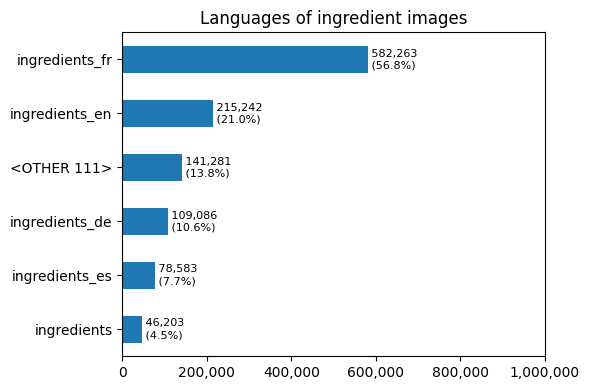

In [7]:
max_count = 5
img_lang = df_images.images_keys.str.split(',').explode()
print(f"Number of ingredient images: {len(img_lang):,}")
top_langs = img_lang.value_counts().head(max_count).index
other_count= len(img_lang.value_counts())-max_count
lang_values = img_lang.map(lambda x: x if x in top_langs else f"<OTHER {other_count}>").value_counts()
display(lang_values.map("{:,}".format))

ax = lang_values.plot.barh(title='Languages of ingredient images', figsize=(6,4))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 1e6)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_images) * 100:.1f}%)', va='center', ha='left', fontsize=8)
    
plt.tight_layout()
plt.show()

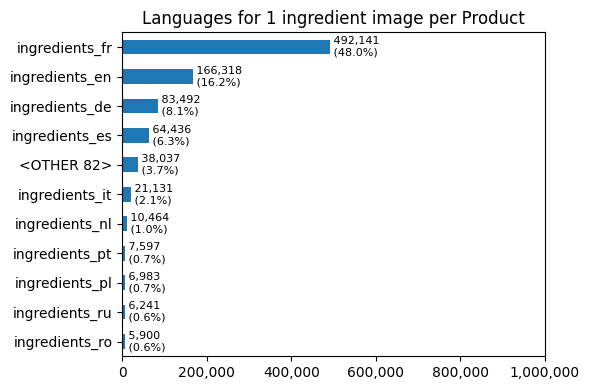

In [8]:
img_lang1 = df_images.images_keys[img_counts == '1']
top_langs1 = img_lang1.value_counts().head(10).index
other_count= len(img_lang1.value_counts())-10

ax = img_lang1.map(lambda x: x if x in top_langs1 else f"<OTHER {other_count}>").value_counts().plot.barh(title='Languages for 1 ingredient image per Product', figsize=(6,4))
ax.invert_yaxis()

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_ylabel(None)
ax.set_xlim(0, 1e6)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_images) * 100:.1f}%)', va='center', ha='left', fontsize=8)
    
plt.tight_layout()
plt.show()

### Language Co-occurrence

In [9]:
import itertools

img_lang2 = df_images.images_keys.str.split(',')[lambda x: x.map(len) >= 2]
langs = img_lang2.explode().value_counts().index
short_langs = langs.str.replace('ingredients', '').str.replace('_', '')

co_occurrence = pd.DataFrame(0, index=langs, columns=langs)
for lang_list in img_lang2:
    for lang1, lang2 in itertools.combinations(lang_list, 2):
        co_occurrence.loc[lang1, lang2] += 1
        co_occurrence.loc[lang2, lang1] += 1

# (Optional) Count individual language occurrences on the diagonal
for lang_list in img_lang2:
    for lang in lang_list:
        co_occurrence.loc[lang, lang] += 1


In [10]:
co_occurrence.columns = short_langs
co_occurrence.index = short_langs
# restrict to first 10 rows and columns
co_occurrence.iloc[:10, :10]

images_keys,fr,en,,de,es,nl,it,pt,sv,pl
images_keys,,,,,,,,,,
fr,90122,29023,36096,16126,6208,7244,5400,1529,857,839
en,29023,48924,5223,7507,4644,3085,2976,1180,1102,1413
,36096,5223,46168,3740,3244,584,631,436,105,176
de,16126,7507,3740,25594,1629,2411,2552,647,628,851
es,6208,4644,3244,1629,14147,994,1066,2265,361,289
nl,7244,3085,584,2411,994,8857,898,472,444,235
it,5400,2976,631,2552,1066,898,8057,439,265,226
pt,1529,1180,436,647,2265,472,439,3803,204,198
sv,857,1102,105,628,361,444,265,204,2813,119


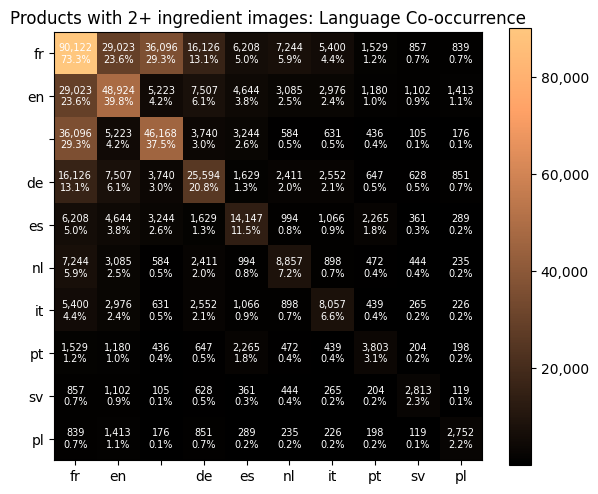

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(co_occurrence.iloc[:10, :10], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(10), short_langs[:10])
plt.yticks(range(10), short_langs[:10])

plt.colorbar(im, ax=ax, format=FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Print the count in each cell
for i in range(10):
    for j in range(10):
        # The co-occurrence value at row i, column j
        value = co_occurrence.iloc[i, j]
        ax.text(j, i, f"{value:,}\n{value / len(img_lang2) * 100:.1f}%",
                ha='center', va='center', color='white', fontsize=7)

plt.title("Products with 2+ ingredient images: Language Co-occurrence")
plt.tight_layout()
plt.show()

## Known + Unknown Ingredients

In [12]:
print("Known:", "{:,}".format(df_images.known_ingredients_n.notna().sum()))
print("Unknown:", "{:,}".format(df_images.unknown_ingredients_n.notna().sum()))
print("Known+Unknown:", "{:,}".format((df_images.known_ingredients_n.notna() & df_images.unknown_ingredients_n.notna()).sum()))

df_identified = df_images[lambda x: x.known_ingredients_n.notna() & x.unknown_ingredients_n.notna()]
"{:.1f}%".format(len(df_identified) / len(df_images) * 100)

Known: 639,044
Unknown: 639,094
Known+Unknown: 639,044


'62.3%'

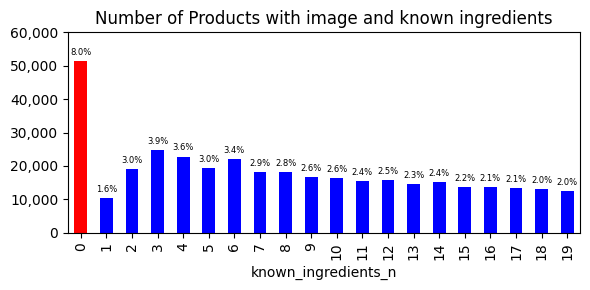

In [13]:
dfx = df_identified.known_ingredients_n.value_counts().sort_index()
#dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['red' if idx == 0 else 'blue' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_identified) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 60000)
plt.title("Number of Products with image and known ingredients")
plt.tight_layout();
#plt.savefig("known_number_ingredients.png");

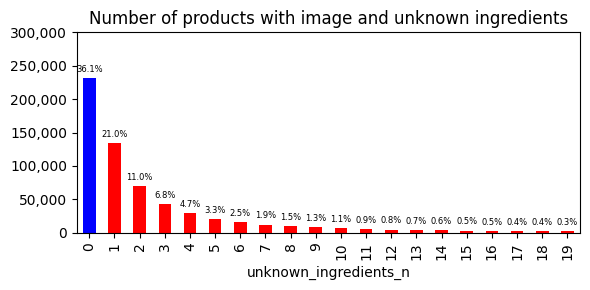

In [14]:
dfx = df_identified.unknown_ingredients_n.value_counts().sort_index()
dfx.index = pd.CategoricalIndex(dfx.index, ordered=True)
colors = ['blue' if idx == 0 else 'red' for idx in dfx[:20].index]

ax = dfx[:20].plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / len(df_identified) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

ax.set_ylim(0, 300000)
plt.title("Number of products with image and unknown ingredients")
plt.tight_layout();
plt.savefig("unknown_number_ingredients.png");

In [15]:
known = df_identified.known_ingredients_n.value_counts().sort_index()
unknown = df_identified.unknown_ingredients_n.value_counts().sort_index()
#co_occurrence = pd.DataFrame(0, index=known.index, columns=unknown.index)
co_occurrence = pd.DataFrame(0, index=unknown.index, columns=known.index)

for _, row in df_identified.iterrows():
    #co_occurrence.loc[row['known_ingredients_n'], row['unknown_ingredients_n']] += 1
    co_occurrence.loc[row['unknown_ingredients_n'], row['known_ingredients_n']] += 1

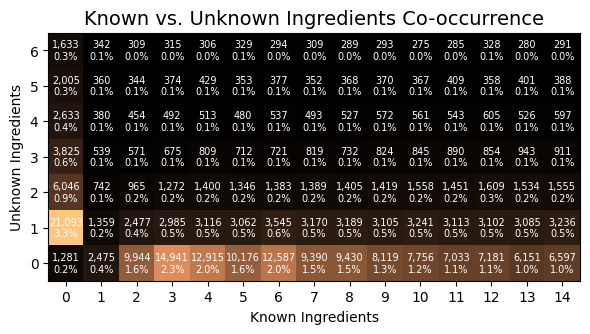

In [16]:
#count = 15
maxx = 15
maxy = 7
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(co_occurrence.iloc[:maxy, :maxx], cmap='copper', interpolation='nearest')

# Show language labels on axes
plt.xticks(range(maxx), range(maxx))
plt.yticks(range(maxy), range(maxy))
plt.xlabel('Known Ingredients')
plt.ylabel('Unknown Ingredients')

ax.invert_yaxis()

#plt.colorbar(im, ax=ax, format=FuncFormatter(lambda x, pos: f'{int(x):,}'))

# Print the count in each cell
for y in range(maxy):
    for x in range(maxx):
        # The co-occurrence value at row i, column j
        value = co_occurrence.iloc[y, x]
        ax.text(x, y, f"{value:,}\n{value / len(df_identified) * 100:.1f}%",
                ha='center', va='center', color='white', fontsize=7)

plt.title("Known vs. Unknown Ingredients Co-occurrence", fontsize=14)
plt.tight_layout()
plt.show()

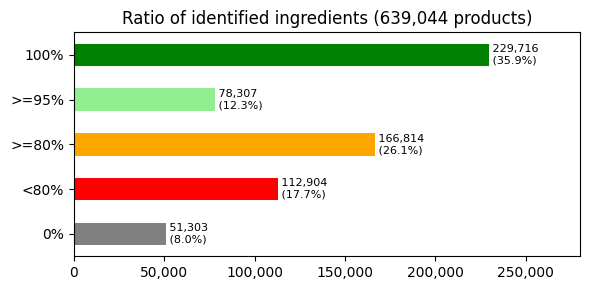

In [17]:
def categorize_ratio(row):
    known = row.known_ingredients_n
    unknown = row.unknown_ingredients_n
    total = known + unknown
    # Avoid division by zero: if total is 0, treat the ratio as 0
    ratio = known / total if total else 0

    if ratio == 1:
        return "100%"
    elif ratio >= 0.95:
        return ">=95%"
    elif ratio >= 0.80:
        return ">=80%"
    elif ratio == 0:
        return "0%"
    else:
        return "<80%"

colors = ['green', 'lightgreen', 'orange', 'red', 'grey']

# Add the new column with the categories
ax = df_identified.apply(categorize_ratio, axis=1).value_counts().reindex(["100%", ">=95%", ">=80%", "<80%", "0%"]).plot.barh(figsize=(6,3), color=colors)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 280000)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_identified) * 100:.1f}%)', va='center', ha='left', fontsize=8)
    
plt.title(f"Ratio of identified ingredients ({len(df_identified):,} products)")
plt.tight_layout()
plt.show()

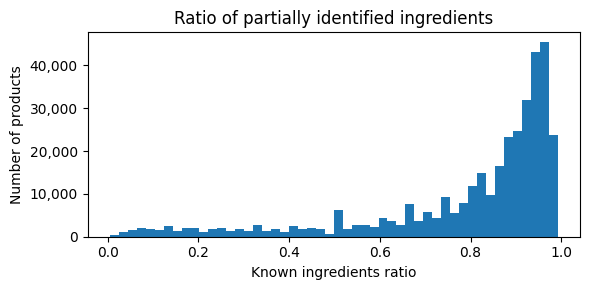

In [18]:
df_ing_partial = df_identified[lambda x: (x.known_ingredients_n > 0) & (x.unknown_ingredients_n > 0)]
df_ing_ratio = df_ing_partial.apply(lambda x: x.known_ingredients_n / (x.known_ingredients_n + x.unknown_ingredients_n), axis=1)

ax = df_ing_ratio.plot.hist(bins=50, title='Ratio of partially identified ingredients', figsize=(6,3))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

plt.xlabel('Known ingredients ratio')
plt.ylabel('Number of products')
plt.tight_layout()
plt.show()

In [19]:
df_images[lambda x: (x.known_ingredients_n == 0) & (x.unknown_ingredients_n == 1)].ingredients_text#.value_counts(dropna=False)

code
0002000000714    Lait de brebis écréme pasteurisé* ferments lac...
0008421422098                 JURATOYS 13 Rue de L'Industrie 39270
00002929                                         Flat leaf parsley
00009034         PITTED CALIFORNIA DRIED PLUMS WITH POTASSIUM S...
00018097                                            Salade Iceberg
                                       ...                        
9300663465910    GagaGlow AXE PROVOKE HAZELNING VANILLA RENT 48...
9555723801829    77 BAD LAB BAD B LOCK & LOAD Solid Texture Hai...
8999999028817    NEW WORLD'S NO.1&quot; SELLING GERM PROTECTION...
0044564030004                                                  NaN
4061461979508                                            Zink-Luft
Name: ingredients_text, Length: 21093, dtype: object

## SELECT IMAGES

```sh
time (
  echo "code,ingredients_n,known_ingredients_n,unknown_ingredients_n,has_analysis_tags,ingredients_percent_analysis,ingredients_text,ingredients_tags,images_keys,images,states,quality_info"
  zcat < openfoodfacts-products.jsonl.gz | jq -r '
  (.images // {}) as $img |
  ($img | to_entries | map(select(.key | startswith("ingred"))) ) as $ingimg |
  def resolve(field):
    if .value.imgid == null then null else $img[ (.value.imgid | tostring) ][field] end;
  [
    .code,
    (if .ingredients_n == null then null else (.ingredients_n | tonumber) end),
    (if .known_ingredients_n == null then null else (.known_ingredients_n | tonumber) end),
    (if .unknown_ingredients_n == null then null else (.unknown_ingredients_n | tonumber) end),
    (if .ingredients_analysis_tags != null then true else false end),
    .ingredients_percent_analysis,
    .ingredients_text,
    (.ingredients_tags | if length > 0 then join(",") else null end),
    ($ingimg | map(.key) | if length > 0 then join(",") else null end),
    ($ingimg
      | map({ key: .key, value: { imgid: .value.imgid, uploader: resolve("uploader"), uploaded_t: resolve("uploaded_t") } })
      | from_entries
      | if length > 0 then tojson else null end
    ),
    (.states_tags // [] | map(select(startswith("en:ingred"))) | if length > 0 then join(",") else null end),
    (.data_quality_info_tags // [] | map(select(startswith("en:ing"))) | if length > 0 then join(",") else null end)
  ]
  | @csv
'
) >ingredients_data_export_jq8.csv
```

## Analyze Ingredient Images in Detail

In [20]:

df_img = df_images.images.map(json.loads)
df_img

code
0000101209159    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000111301201    {'ingredients_en': {'imgid': '1', 'uploader': ...
0000140323687    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000141013129    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000171812457    {'ingredients_fr': {'imgid': '2', 'uploader': ...
                                       ...                        
5712875905025    {'ingredients_da': {'imgid': '2', 'uploader': ...
5708229104138    {'ingredients_da': {'imgid': '2', 'uploader': ...
5712874520052    {'ingredients_da': {'imgid': '2', 'uploader': ...
5000159571463    {'ingredients_en': {'imgid': '2', 'uploader': ...
8010995007078    {'ingredients_it': {'imgid': 2, 'uploader': 't...
Name: images, Length: 1025741, dtype: object

### Ingredient Images with null values for `uploader` or `uploaded_t`

In [21]:
df_none = df_img.map(lambda x: {k:x[k] for k in x.keys() if x[k]['uploader'] is None or x[k]['uploaded_t'] is None})
df_none[lambda x: x.map(len) > 0]

code
0028435398622    {'ingredients_en': {'imgid': '2', 'uploader': ...
0051500042311    {'ingredients_fr': {'imgid': '3', 'uploader': ...
0055742509427    {'ingredients_fr': {'imgid': '3', 'uploader': ...
00530361         {'ingredients_lc': {'imgid': '5', 'uploader': ...
0068400021131    {'ingredients_en': {'imgid': '4', 'uploader': ...
                                       ...                        
5711657027467    {'ingredients_da': {'imgid': '3', 'uploader': ...
4316268707374    {'ingredients_de': {'imgid': '2', 'uploader': ...
7025110210968    {'ingredients_nb': {'imgid': '3', 'uploader': ...
4061462867804    {'ingredients_en': {'imgid': '2', 'uploader': ...
4088700037270    {'ingredients_en': {'imgid': '3', 'uploader': ...
Name: images, Length: 792, dtype: object

### Remove ingredient images with null values

In [22]:
df_img_clean = df_img.map(lambda x: {k:x[k] for k in x.keys() if x[k]['uploader'] is not None and x[k]['uploaded_t'] is not None})[lambda x: x.map(len) > 0]
df_img_clean

code
0000101209159    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000111301201    {'ingredients_en': {'imgid': '1', 'uploader': ...
0000140323687    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000141013129    {'ingredients_fr': {'imgid': '2', 'uploader': ...
0000171812457    {'ingredients_fr': {'imgid': '2', 'uploader': ...
                                       ...                        
5712875905025    {'ingredients_da': {'imgid': '2', 'uploader': ...
5708229104138    {'ingredients_da': {'imgid': '2', 'uploader': ...
5712874520052    {'ingredients_da': {'imgid': '2', 'uploader': ...
5000159571463    {'ingredients_en': {'imgid': '2', 'uploader': ...
8010995007078    {'ingredients_it': {'imgid': 2, 'uploader': 't...
Name: images, Length: 1025187, dtype: object

### Image Uploader

In [23]:
df_uploader = df_img_clean.map(lambda x: [x[k]['uploader'] for k in x.keys()])

In [24]:
df_uploader.explode().value_counts()

images
kiliweb                       443051
openfoodfacts-contributors    102497
inf                            60289
smoothie-app                   54261
elcoco                         31859
                               ...  
ross-holloway94                    1
edtwinkle                          1
koprivaqi                          1
darmilo                            1
vikkis                             1
Name: count, Length: 52474, dtype: int64

### Upload Time

In [25]:
# Convert times stamps (as int or str) to datetime
df_dates = df_img_clean.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])
df_dates
#.explode().dt.year.value_counts().sort_index()

/var/folders/yz/vvwzcc9178l36z8l4fc42bkm0000gn/T/ipykernel_56219/1675645873.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_dates = df_img_clean.map(lambda x: [pd.to_datetime(x[k]['uploaded_t'], unit='s') for k in x.keys()])


code
0000101209159    [2018-02-22 10:57:04]
0000111301201    [2021-09-25 23:17:16]
0000140323687    [2018-08-27 10:13:12]
0000141013129    [2018-09-01 06:06:28]
0000171812457    [2018-05-01 12:22:24]
                         ...          
5712875905025    [2025-03-16 10:01:03]
5708229104138    [2025-03-16 10:03:55]
5712874520052    [2025-03-16 10:07:15]
5000159571463    [2025-03-16 10:17:25]
8010995007078    [2025-03-16 10:26:48]
Name: images, Length: 1025187, dtype: object

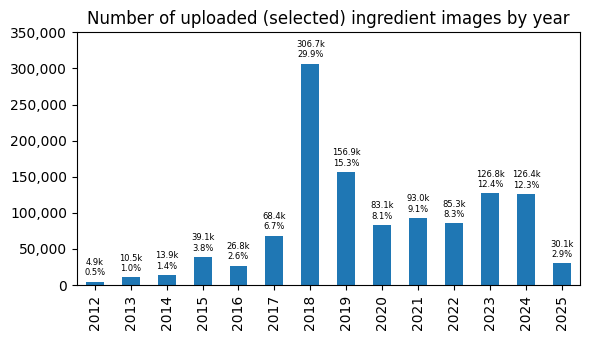

In [26]:
# explode and count the years
ax = df_dates.explode().dt.year.value_counts().sort_index().astype(int).plot.bar(figsize=(6,3.5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))

# Annotate each bar with its value
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / 1000:.1f}k\n{height / len(df_images) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)
    
ax.set_ylim(0, 350000)

ax.set_title("Number of uploaded (selected) ingredient images by year")
ax.set_xlabel(None)

plt.tight_layout()

### Age of uploaded ingredient images (as of today)

In [27]:
from dateutil.relativedelta import relativedelta

df_year = df_dates.map(sorted).map(lambda x: relativedelta(pd.Timestamp.today(), x[-1]).years)


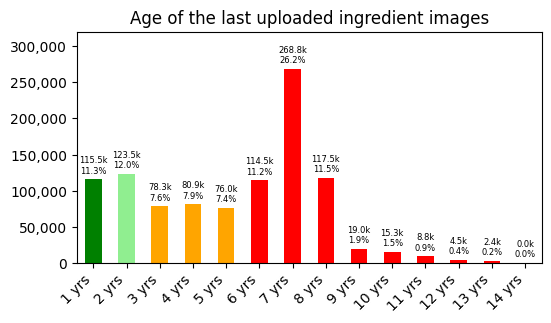

In [28]:
per_year = df_year.value_counts().sort_index()
#cumsum = df_year.value_counts().sort_index().cumsum()

colors = ['green' if idx == 0 else 'lightgreen' if idx == 1 else 'orange' if idx<5 else 'red' for idx in dfx[:20].index]

ax = per_year.plot.bar(figsize=(6,3), color=colors)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x)+1} yrs'))

ax.set_xlabel(None)
#ax.set_ylabel("Cumulative count of images")
plt.xticks(rotation=45, ha='right')
plt.title("Age of the last uploaded ingredient images")
ax.set_ylim(0, 320000)

for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height / 1000:.1f}k\n{height / len(df_year) * 100:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text slightly above the bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

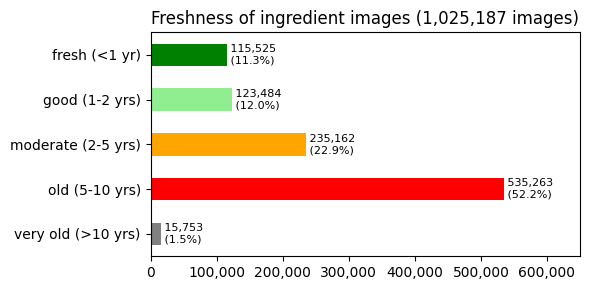

In [29]:
def categorize_age(year: int):
    if year == 0:
        return "fresh (<1 yr)"
    elif year == 1:
        return "good (1-2 yrs)"
    elif year < 5:
        return "moderate (2-5 yrs)"
    elif year < 10:
        return "old (5-10 yrs)"
    else:
        return "very old (>10 yrs)"

colors = ['green', 'lightgreen', 'orange', 'red', 'grey']

ax = df_year.map(categorize_age).value_counts().reindex(["fresh (<1 yr)", "good (1-2 yrs)", "moderate (2-5 yrs)", "old (5-10 yrs)", "very old (>10 yrs)"]).plot.barh(figsize=(6,3), color=colors)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.invert_yaxis()
ax.set_xlim(0, 650000)
ax.set_ylabel(None)

for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height() / 2,
            f' {width:,}\n ({width / len(df_year) * 100:.1f}%)', va='center', ha='left', fontsize=8)

plt.title(f"Freshness of ingredient images ({len(df_year):,} images)")
plt.tight_layout()
plt.show()


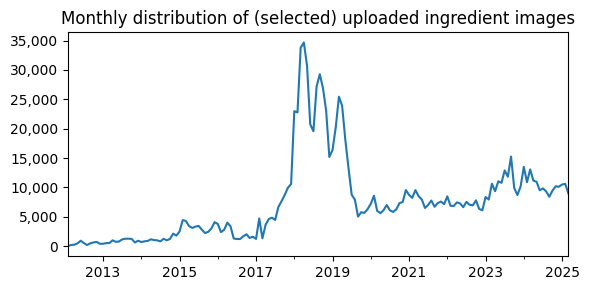

In [30]:
# aggregate by month
df_uploaded_month = df_dates.explode().dt.to_period('M')
ax = df_uploaded_month.value_counts().sort_index().plot(figsize=(6,3), title='Monthly distribution of (selected) uploaded ingredient images')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y):,}'))
plt.xlabel(None)
plt.tight_layout()
plt.show()